In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import torch
import seaborn as sns

### FUNCIONES DE PÉRDIDA EN EL ENTRENAMIENTO

In [2]:
train_path = 'Results_population/train_metrics'
file_list = os.listdir(train_path)
datasets = file_list
datasets

['fulsang_data', 'hugo_data', 'jaulab_data']

In [37]:
# SELECT THE DATASET
dataset = datasets[1]

In [38]:
jaulab_excl_subj = [13, 16]
ds_subjects = {'fulsang': ['S'+str(n) for n in range(1, 18)], 'jaulab': ['S'+str(n) for n in range(1,18) if n not in jaulab_excl_subj], 'hugo': ['S'+str(n) for n in range(1,10)]}
subjects = ds_subjects[dataset.split('_')[0]]

In [39]:
train_metrics = {}
models = ['FCNN', 'CNN']
sets = ['train', 'val']

key = '02_08'

for model in models:
    for set in sets:
        path = os.path.join(train_path, dataset, set, model+'_'+key)
        file_list = os.listdir(path)
        train_metrics[model+'_'+set] = {}
        for file in file_list:
            for subj in subjects:
                if subj in file:
                    if subj == 'S1':
                        idx = file.index(subj)
                        if file[idx+2] == '_': # si el siguiente caracter al S1 es un barra baja añade al diccionario    
                            loss = json.load(open(os.path.join(path,file), 'r'))
                            train_metrics[model+'_'+set][subj] = loss
                    else:   
                        loss = json.load(open(os.path.join(path,file), 'r'))
                        train_metrics[model+'_'+set][subj] = loss

epocas = len(train_metrics['FCNN_train']['S1'])
print(f'Epocas {epocas}')               

Epocas 12


In [40]:
def get_subject(n, n_subject):
    subjects = ['S'+str(i+1) for i in range(n_subject)]
    return subjects[n]

9
['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9']


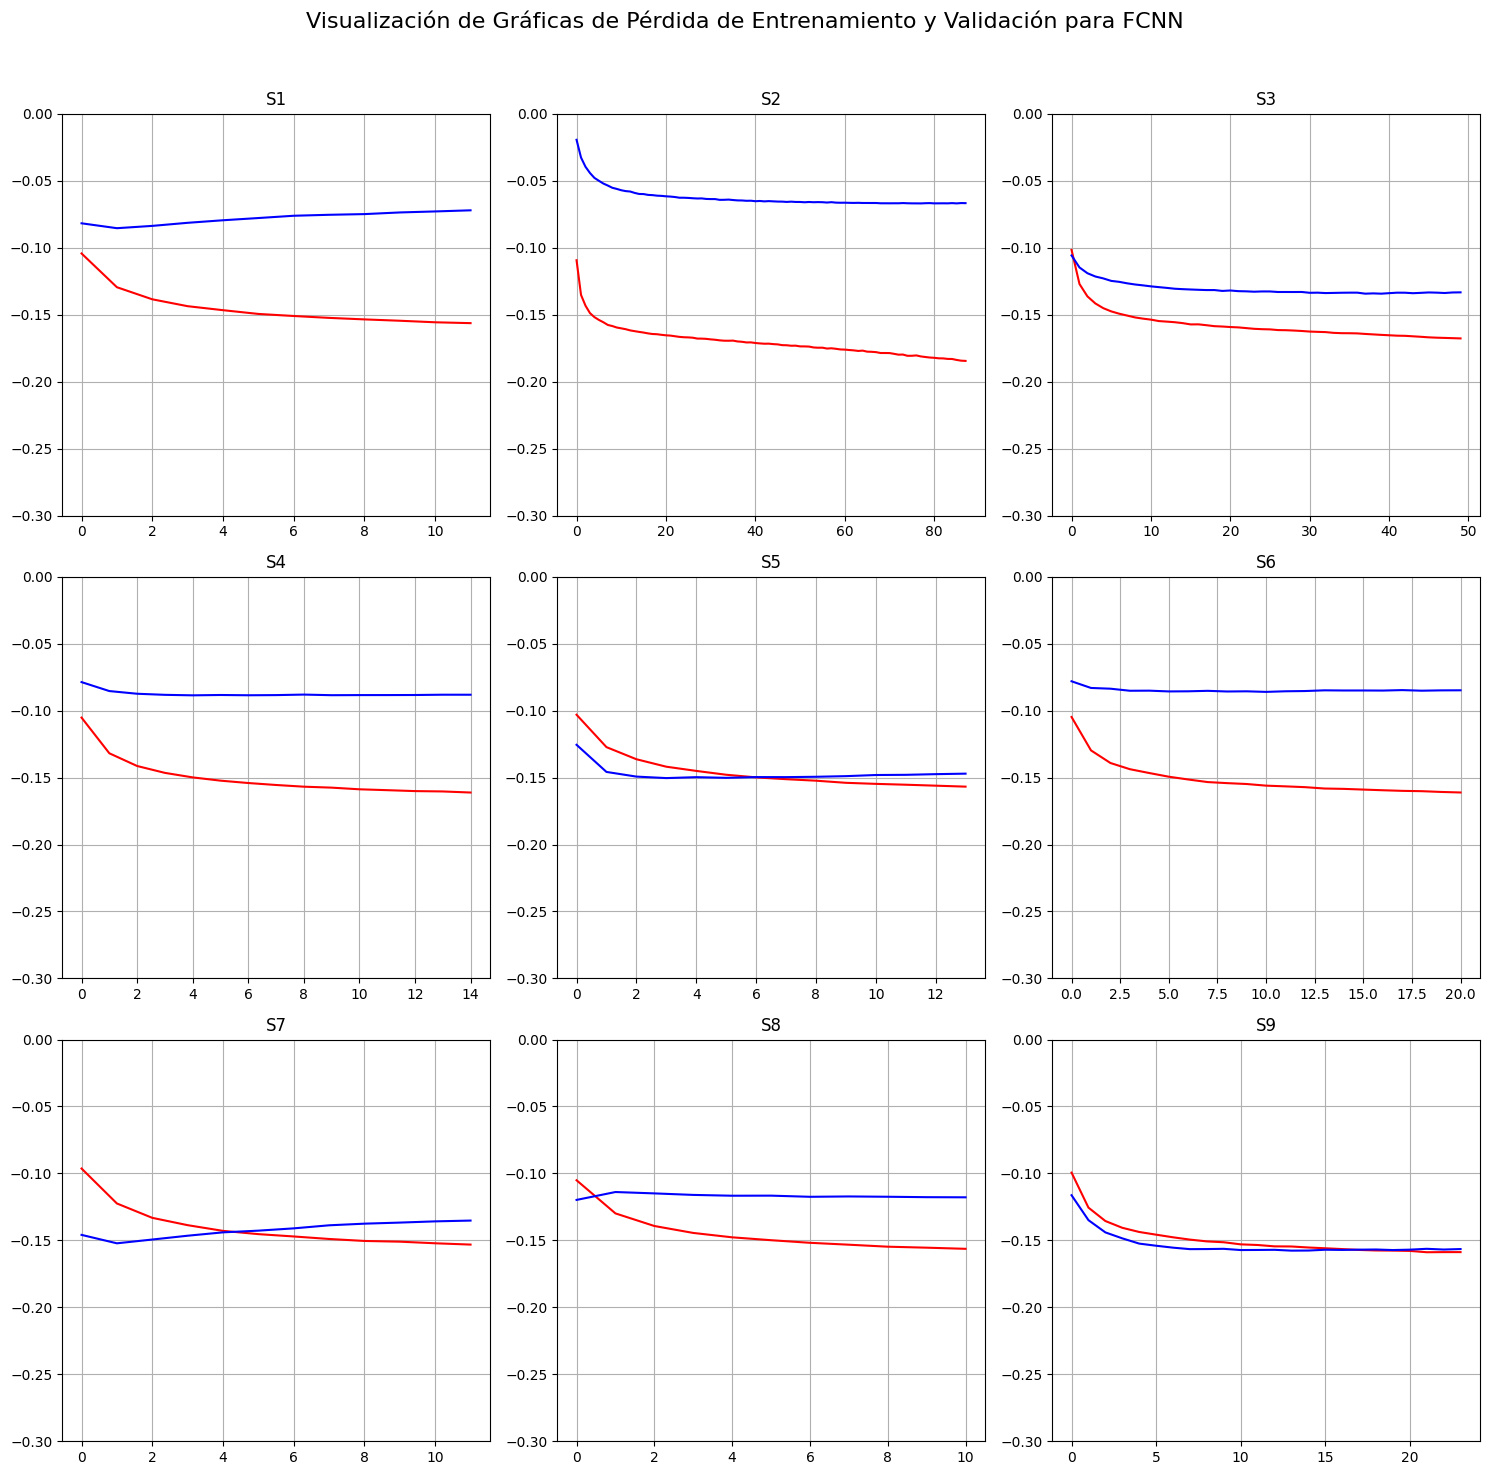

In [41]:
# Seleccionar FCNN o CNN
mode = 'FCNN'
n_subj = len(train_metrics[mode+'_val'])
print(n_subj)

n_plots = n_subj

# Calcular el número de filas necesarias
n_rows = (n_plots + 2) // 3

# Creo la figura y una matriz de subfiguras
fig, axs = plt.subplots(nrows=n_rows, ncols=3, figsize=(15, 5 * n_rows))

# Aplanar la matriz de subfiguras para un acceso fácil
axs = axs.flatten()

print(subjects)
idx = 0
for n, subj in enumerate(subjects):
    train_loss = torch.tensor(train_metrics[mode+'_train'][subj])
    val_loss = torch.tensor(train_metrics[mode+'_val'][subj])
    x = range(len(val_loss))
    
    axs[idx].plot(x, -train_loss, linestyle = '-', color='r')
    axs[idx].plot(x, -val_loss, linestyle = '-', color= 'b')
    axs[idx].set_ylim(-0.3, 0)
    axs[idx].set_title(subj)
    axs[idx].grid(True)
    idx += 1

# Eliminar subfiguras vacías si hay menos subfiguras que lugares en la cuadrícula
for ax in axs[idx:]:
    fig.delaxes(ax)

plt.tight_layout()
# Agregar un título general a la figura
fig.suptitle('Visualización de Gráficas de Pérdida de Entrenamiento y Validación para '+ mode, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajustar el layout para dejar espacio para el título

plt.show()

### MOSTRAR RESULTADOS EVALUACIÓN

In [69]:
eval_path = 'Results_population/eval_metrics'

file_list = os.listdir(eval_path)
datasets = file_list
datasets

['fulsang_data', 'hugo_data', 'jaulab_data']

In [70]:
jaulab_excl_subj = [13, 16]
ds_subjects = {'fulsang': ['S'+str(n) for n in range(1, 18)], 'jaulab': ['S'+str(n) for n in range(1,18) if n not in jaulab_excl_subj], 'hugo': ['S'+str(n) for n in range(1,10)]}

fulsang_data
CNN_02_08: 0.06709411764705883
FCNN_02_08: 0.06836470588235295
hugo_data
CNN_02_08: 0.09948888888888889
FCNN_02_08: 0.09565555555555555
jaulab_data
CNN_02_08: 0.022313333333333334
FCNN_02_08: 0.02362


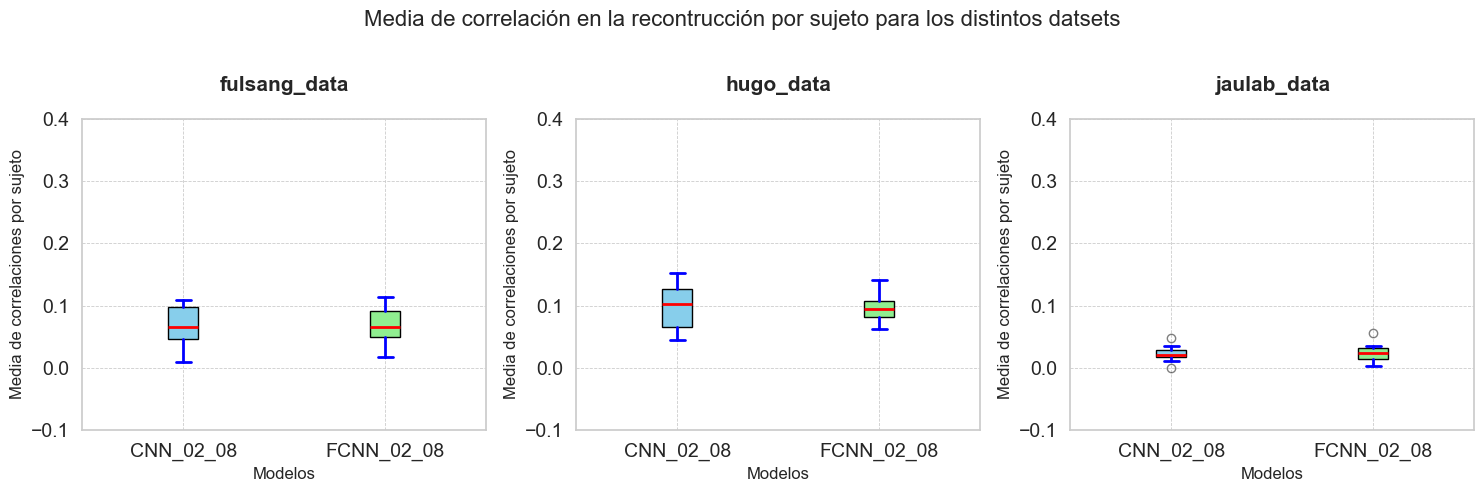

In [72]:
# COMPARACIÓN DE DATASETS

n_plots = len(datasets)

# Calcular el número de filas necesarias
n_rows = (n_plots + 2) // 3

# Creo la figura y una matriz de subfiguras
fig, axs = plt.subplots(nrows=n_rows, ncols=3, figsize=(15, 5 * n_rows))

axs = axs.flatten()

for n, dataset in enumerate(datasets):

    path = os.path.join(eval_path, dataset)
    file_list = os.listdir(path)

    results = {}

    # Load data from the folder of results
    for file in file_list:
        str_chunks = file.split('_')
        if str_chunks[1].isdigit():
            model = str_chunks[0]
            date = str_chunks[1] + '_' + str_chunks[2]
        else:
            model = str_chunks[0] + '_' + str_chunks[1]
            date = str_chunks[2] + '_' + str_chunks[3]
        
        eval_results = json.load(open(os.path.join(eval_path,dataset,file),'r'))
        key = model + '_' + date
        results[key] = eval_results

    subjects = ds_subjects[dataset.split('_')[0]]

    # mean score of each subject by computing it with all the samples
    for key, values in results.items():
        results[key] = [np.mean(values[subj]) for subj in subjects]

    print(dataset)
    for key, values in results.items():
        print(key +': ' + str(np.mean([round(value, 4) for value in values])))

    box = axs[n].boxplot([values for values in list(results.values())], vert=True, patch_artist=True)

    # Colores personalizados
    colors = ['skyblue', 'lightgreen', 'lightcoral']

    # Aplicar colores a cada caja
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    # Personalizar otros elementos del gráfico
    for whisker in box['whiskers']:
        whisker.set(color='blue', linewidth=2)

    for cap in box['caps']:
        cap.set(color='blue', linewidth=2)

    for median in box['medians']:
        median.set(color='red', linewidth=2)

    for flier in box['fliers']:
        flier.set(marker='o', color='red', alpha=0.5)

    # Añadir título y etiquetas
    axs[n].set_title(dataset, fontsize=15, fontweight='bold', pad=20)
    axs[n].set_xlabel('Modelos', fontsize=12)
    axs[n].set_ylabel('Media de correlaciones por sujeto')
    axs[n].set_ylim([-0.1,0.4])
    axs[n].set_xticks([n+1 for n in range(len(results))], [key for key in results.keys()], fontsize=14)  # Etiquetas personalizadas

    # Añadir rejilla para mayor legibilidad
    axs[n].grid(True, linestyle='--', linewidth=0.6)

    # Personalizar ejes
    axs[n].tick_params(axis='both', which='major', labelsize=14)

# Eliminar subfiguras vacías si hay menos subfiguras que lugares en la cuadrícula
for ax in axs[n+1:]:
    fig.delaxes(ax)

plt.tight_layout()
# Agregar un título general a la figura
fig.suptitle('Media de correlación en la recontrucción por sujeto para los distintos datsets', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajustar el layout para dejar espacio para el título


# Mostrar el gráfico
plt.show()

In [76]:
# SELECCIONO EL DATASET
dataset = 'hugo'+'_data'
path = os.path.join(eval_path, dataset)
file_list = os.listdir(path)
file_list

['CNN_02_08_Results', 'FCNN_02_08_Results']

[0.09185791854152753, 0.06480861418871524, 0.15174420916020942, 0.06527292140695415, 0.10205474073305762, 0.04442163803479702, 0.13220491622358668, 0.12706400339660665, 0.11585499195984884]
CNN_02_08: 0.09948888888888889
[0.08605439017936227, 0.07255402283325728, 0.14078574600811725, 0.08237091475503816, 0.09493612455528068, 0.062121364264411554, 0.09701023975067777, 0.11774493896272788, 0.10730704720635957]
FCNN_02_08: 0.09565555555555555
2


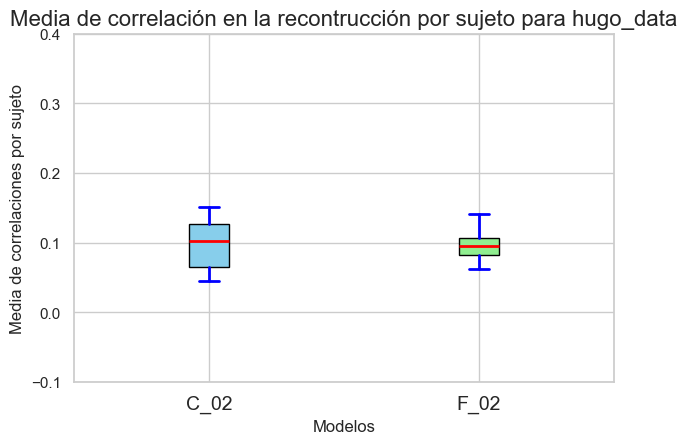

In [77]:
# MUESTRA SOLO UN DATASET

path = os.path.join(eval_path, dataset)
file_list = os.listdir(path)
file_list

results = {}

# Load data from the folder of results
for file in file_list:
    str_chunks = file.split('_')
    if str_chunks[1].isdigit():
        model = str_chunks[0]
        date = str_chunks[1] + '_' + str_chunks[2]
    else:
        model = str_chunks[0] + '_' + str_chunks[1]
        date = str_chunks[2] + '_' + str_chunks[3]
    
    if date != '30_07': # Not taking a specific simulation
        eval_results = json.load(open(os.path.join(eval_path,dataset,file),'r'))
        key = model + '_' + date
        results[key] = eval_results

subjects = ds_subjects[dataset.split('_')[0]]

# mean score of each subject by computing it with all the samples
for key, values in results.items():
    results[key] = [np.mean(values[subj]) for subj in subjects]

for key, values in results.items():
    print(values)
    print(key +': ' + str(np.mean([round(value, 4) for value in values])))

box = plt.boxplot([values for values in list(results.values())], vert=True, patch_artist=True)

# Colores personalizados
colors = ['skyblue', 'lightgreen', 'lightcoral']

# Aplicar colores a cada caja
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Personalizar otros elementos del gráfico
for whisker in box['whiskers']:
    whisker.set(color='blue', linewidth=2)

for cap in box['caps']:
    cap.set(color='blue', linewidth=2)

for median in box['medians']:
    median.set(color='red', linewidth=2)

for flier in box['fliers']:
    flier.set(marker='o', color='red', alpha=0.5)

# Añadir título y etiquetas
plt.xlabel('Modelos', fontsize=12)
plt.ylabel('Media de correlaciones por sujeto')
plt.ylim([-0.1,0.4])
print(len(results))
plt.xticks([n+1 for n in range(len(results))], [key.split('_')[0][0] + '_' + key.split('_')[1] for key in results.keys()], fontsize=14)  # Etiquetas personalizadas

# Añadir rejilla para mayor legibilidad
axs[n].grid(True, linestyle='--', linewidth=0.6)

# Personalizar ejes
axs[n].tick_params(axis='both', which='major', labelsize=14)

# Agregar un título general a la figura
plt.title('Media de correlación en la recontrucción por sujeto para ' + dataset, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajustar el layout para dejar espacio para el título


# Mostrar el gráfico
plt.show()

In [78]:
path = os.path.join(eval_path, dataset)
file_list = os.listdir(path)
file_list

results = []

# Load data from the folder of results
for file in file_list:
    str_chunks = file.split('_')
    if str_chunks[1].isdigit():
        model = str_chunks[0]
        date = str_chunks[1] + '_' + str_chunks[2]
    else:
        model = str_chunks[0] + '_' + str_chunks[1]
        date = str_chunks[2] + '_' + str_chunks[3]
    
    eval_results = json.load(open(os.path.join(eval_path,dataset,file),'r'))
    key = model + '_' + date
    print(key)
    results.append(eval_results)

len(results)
CNN_Results = results[0]
FCNN_Results = results[1]

CNN_02_08
FCNN_02_08


In [79]:
n_subjects = len(CNN_Results)
subjects = ['S'+str(n+1) for n in range(n_subjects)]

In [80]:
# MOSTRAR MEDIAS
means = {subj:np.mean(results) for subj, results in CNN_Results.items()}
means

{'S1': 0.09185791854152753,
 'S2': 0.06480861418871524,
 'S3': 0.15174420916020942,
 'S4': 0.06527292140695415,
 'S5': 0.10205474073305762,
 'S6': 0.04442163803479702,
 'S7': 0.13220491622358668,
 'S8': 0.12706400339660665,
 'S9': 0.11585499195984884}

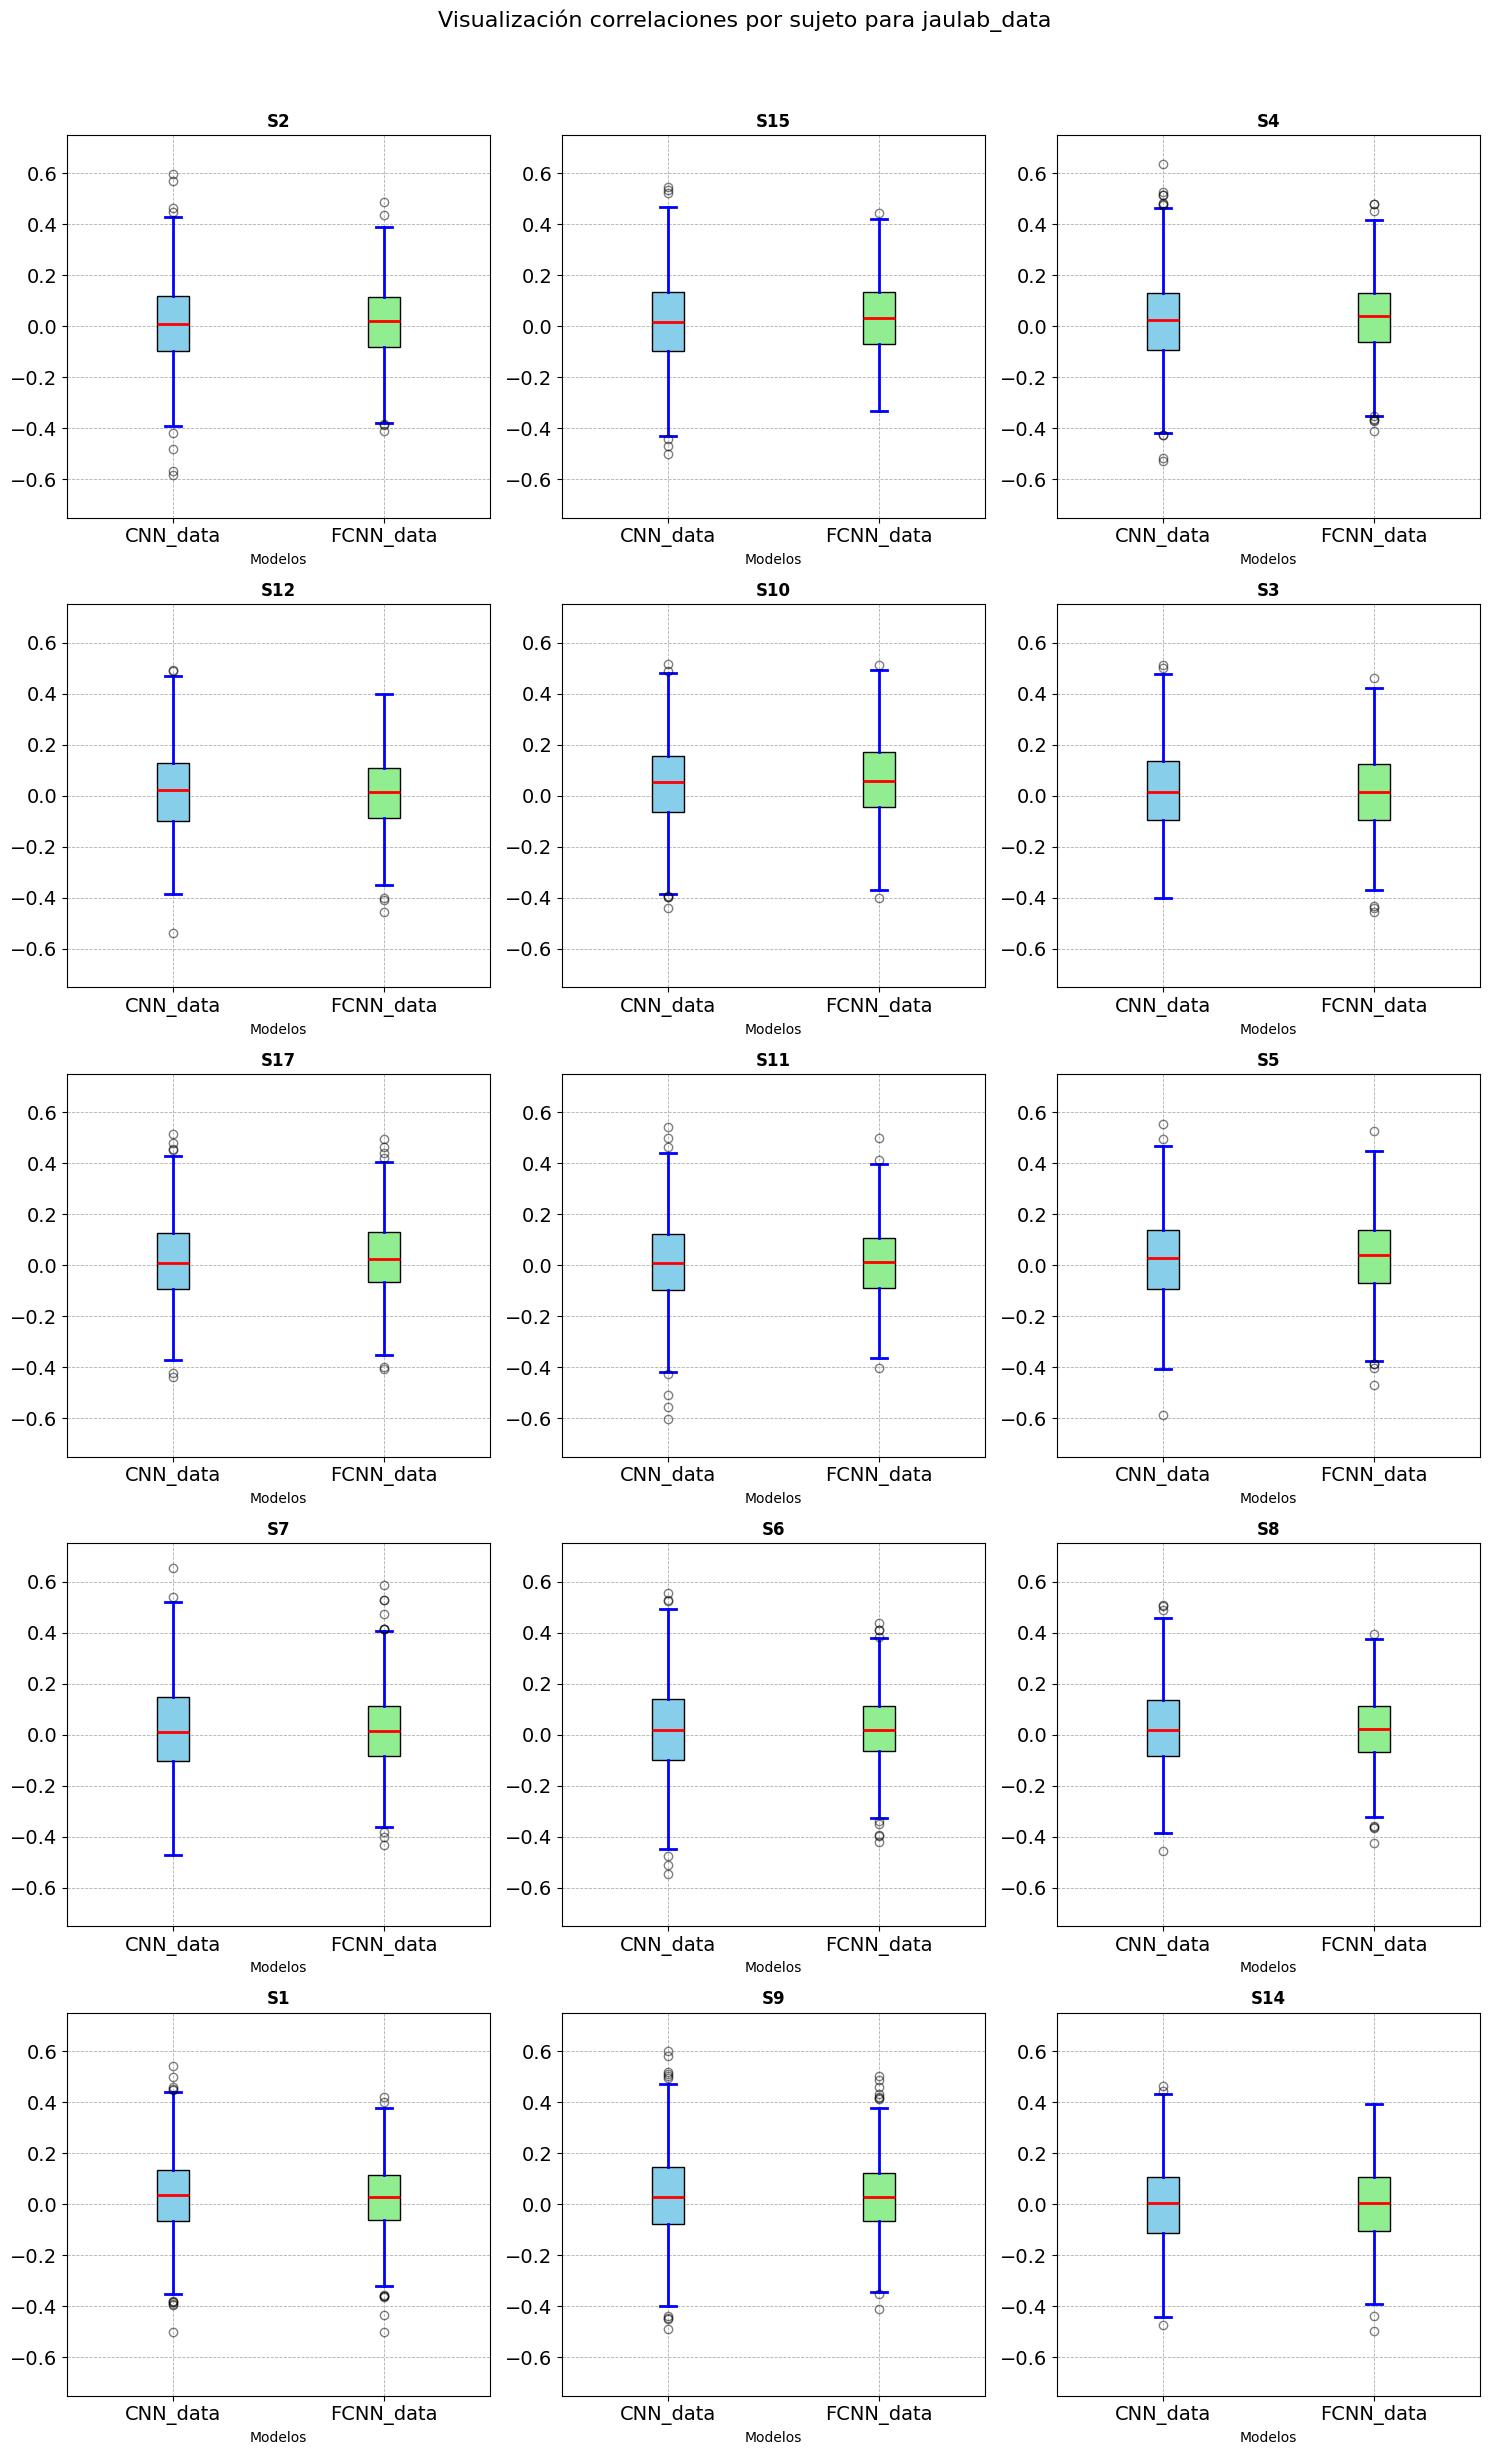

In [58]:
n_plots = len(FCNN_Results.keys())

# Calcular el número de filas necesarias
n_rows = (n_plots + 2) // 3

# Creo la figura y una matriz de subfiguras
fig, axs = plt.subplots(nrows=n_rows, ncols=3, figsize=(15, 5 * n_rows))

# Aplanar la matriz de subfiguras para un acceso fácil
axs = axs.flatten()

for idx, subj in enumerate(CNN_Results.keys()):
    
    # CNN_data = list(-np.array(CNN_Results[subj]))
    CNN_data = CNN_Results[subj]
    FCNN_data = FCNN_Results[subj]

    box = axs[idx].boxplot([CNN_data, FCNN_data], vert=True, patch_artist=True)
    
    # Colores personalizados
    colors = ['skyblue', 'lightgreen', 'lightcoral']
    
    # Aplicar colores a cada caja
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    # Personalizar otros elementos del gráfico
    for whisker in box['whiskers']:
        whisker.set(color='blue', linewidth=2)
    
    for cap in box['caps']:
        cap.set(color='blue', linewidth=2)
    
    for median in box['medians']:
        median.set(color='red', linewidth=2)
    
    for flier in box['fliers']:
        flier.set(marker='o', color='red', alpha=0.5)
    
    # Añadir título y etiquetas
    axs[idx].set_title(subj, fontweight='bold')
    axs[idx].set_xlabel('Modelos')
    axs[idx].set_xticks([1, 2], ['CNN_data', 'FCNN_data'])  # Etiquetas personalizadas
    axs[idx].set_ylim([-0.75, 0.75])
    
    # Añadir rejilla para mayor legibilidad
    axs[idx].grid(True, linestyle='--', linewidth=0.6)
    
    # Personalizar ejes
    axs[idx].tick_params(axis='both', which='major', labelsize=14)

# Eliminar subfiguras vacías si hay menos subfiguras que lugares en la cuadrícula
for ax in axs[idx+1:]:
    fig.delaxes(ax)

plt.tight_layout()
# Agregar un título general a la figura
fig.suptitle('Visualización correlaciones por sujeto para '+ dataset, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajustar el layout para dejar espacio para el título

plt.show()

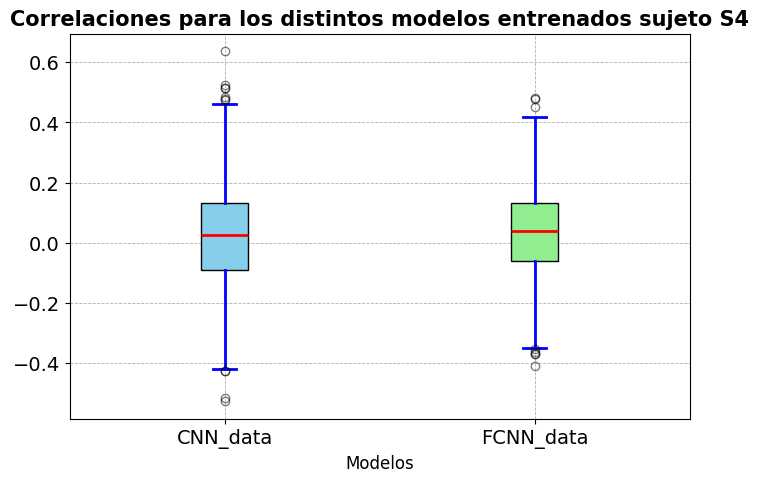

In [59]:
# EJEMPLO POR SUJETO
subj = subjects[3]
CNN_data = CNN_Results[subj]
FCNN_data = FCNN_Results[subj]

plt.figure(figsize=(8, 5))  # Tamaño de la figura

# Crear el gráfico de cajas
box = plt.boxplot([CNN_data, FCNN_data], vert=True, patch_artist=True)

# Colores personalizados
colors = ['skyblue', 'lightgreen', 'lightcoral']

# Aplicar colores a cada caja
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Personalizar otros elementos del gráfico
for whisker in box['whiskers']:
    whisker.set(color='blue', linewidth=2)

for cap in box['caps']:
    cap.set(color='blue', linewidth=2)

for median in box['medians']:
    median.set(color='red', linewidth=2)

for flier in box['fliers']:
    flier.set(marker='o', color='red', alpha=0.5)

# Añadir título y etiquetas
plt.title('Correlaciones para los distintos modelos entrenados sujeto '+subj, fontsize=15, fontweight='bold')
plt.xlabel('Modelos', fontsize=12)
plt.xticks([1, 2], ['CNN_data', 'FCNN_data'], fontsize=14)  # Etiquetas personalizadas

# Añadir rejilla para mayor legibilidad
plt.grid(True, linestyle='--', linewidth=0.6)

# Personalizar ejes
plt.tick_params(axis='both', which='major', labelsize=14)

# Mostrar el gráfico
plt.show()

### DECODING ACCURACIES

In [61]:
# Cargo los diccionarios:
def get_times(dataset, model):
    path = os.path.join('Results_population/decode_accuracy/', dataset+'_data' , model)
    file_list = os.listdir(path)
    # times is a dict with { 'WL_date' : [list with accuracies for each subject] }
    times = {str(int(int(file.split('_')[2]) / 64)) + '_' + file.split('_')[0] + '_' + file.split('_')[1] : json.load(open(os.path.join(path, file),'r')) for file in file_list}
    ordered_keys = dict(sorted(times.items(), key=lambda item: int(item[0].split('_')[0])))
    times_ordered = {key: times[key] for key in ordered_keys if '_'.join(key.split('_')[1:]) != '30_07'}
    return times_ordered

print(get_times('jaulab', 'CNN').keys())

dict_keys(['2_02_08', '10_02_08', '25_02_08', '50_02_08'])


In [62]:
dataset = 'fulsang'
models = ['FCNN', 'CNN']
model_info = {model: get_times(dataset, model) for model in models}

In [63]:
# diccionario agrupando por índices de tiempo y modelos
time_keys = model_info[models[0]].keys()
print(time_keys)
times_info = {time: {model: model_info[model][time] for model in models} for time in time_keys}

dict_keys(['2_02_08', '10_02_08', '25_02_08', '50_02_08'])


2_02_08
CNN: 55.88148148148148
FCNN: 56.333333333333336
10_02_08
CNN: 55.98518518518519
FCNN: 56.42962962962963
50_02_08
CNN: 56.14074074074074
FCNN: 56.40740740740741


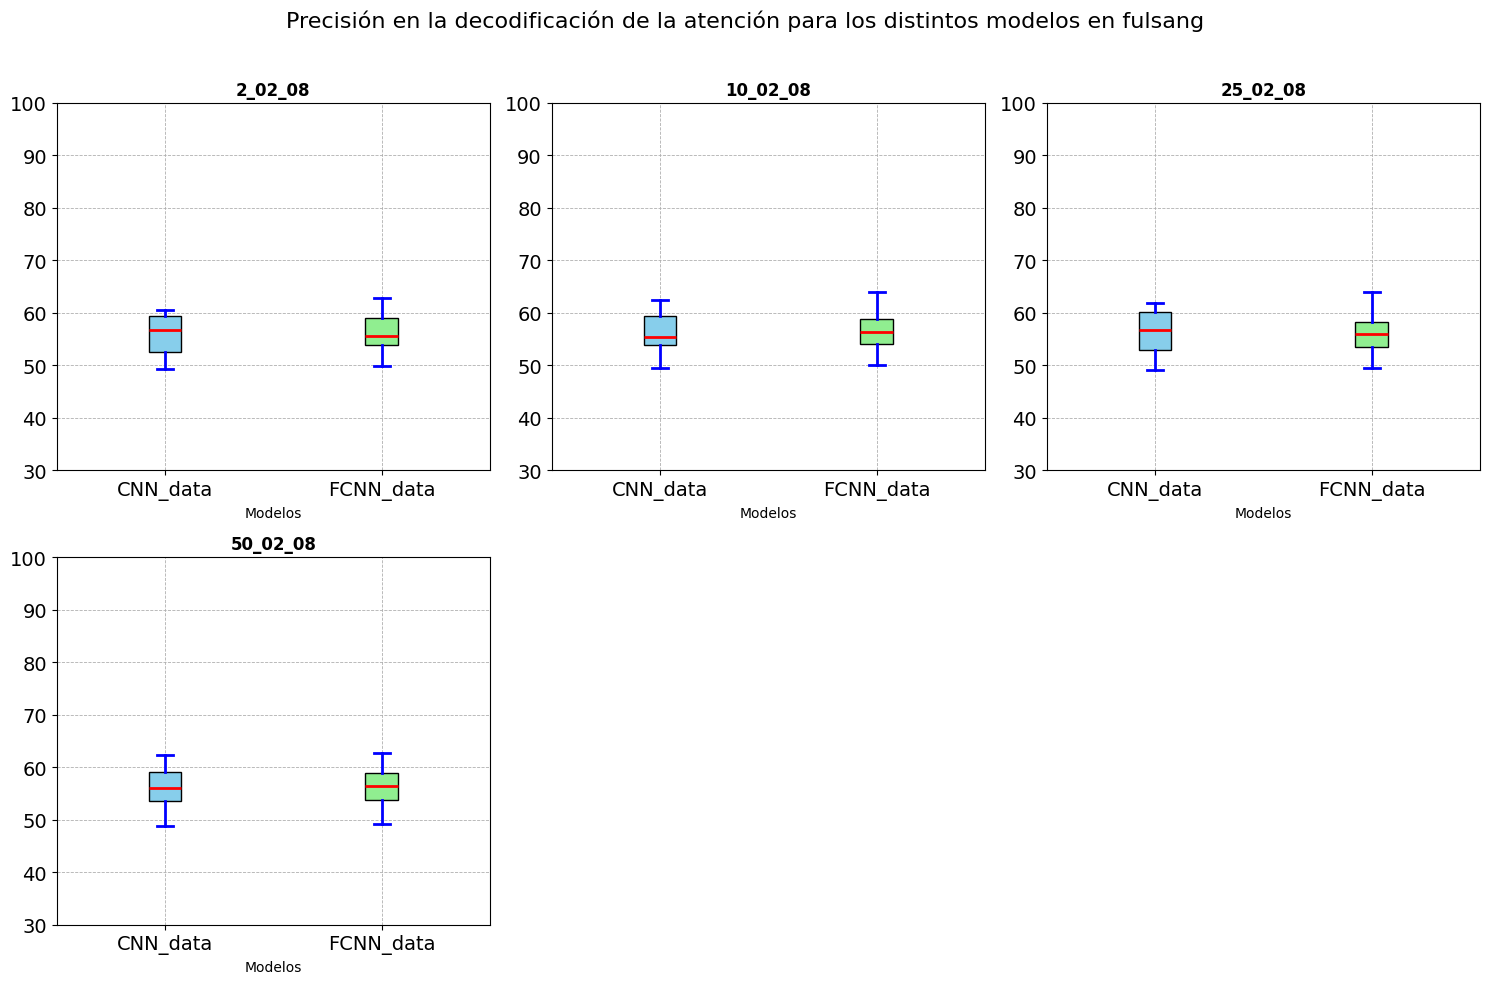

In [66]:
n_plots = len(times_info.keys())

# Calcular el número de filas necesarias
n_rows = (n_plots + 2) // 3

# Creo la figura y una matriz de subfiguras
fig, axs = plt.subplots(nrows=n_rows, ncols=3, figsize=(15, 5 * n_rows))

# Aplanar la matriz de subfiguras para un acceso fácil
axs = axs.flatten()

for n, (idx, mdl_info) in enumerate(times_info.items()):

    models = ['CNN', 'FCNN']
    ventanas_media = ['2', '10', '50']

    if idx.split('_')[0] in ventanas_media:
        print(idx)
        for model in models:
            print(f'{model}: {np.mean(mdl_info[model])}')

    box = axs[n].boxplot([mdl_info[model] for model in models], vert=True, patch_artist=True)
    
    # Colores personalizados
    colors = ['skyblue', 'lightgreen', 'lightcoral']
    
    # Aplicar colores a cada caja
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    # Personalizar otros elementos del gráfico
    for whisker in box['whiskers']:
        whisker.set(color='blue', linewidth=2)
    
    for cap in box['caps']:
        cap.set(color='blue', linewidth=2)
    
    for median in box['medians']:
        median.set(color='red', linewidth=2)
    
    for flier in box['fliers']:
        flier.set(marker='o', color='red', alpha=0.5)
    
    # Añadir título y etiquetas
    axs[n].set_title(idx, fontweight='bold')
    axs[n].set_xlabel('Modelos')
    axs[n].set_xticks([1, 2], ['CNN_data', 'FCNN_data'])  # Etiquetas personalizadas
    axs[n].set_ylim([30,100])
    
    # Añadir rejilla para mayor legibilidad
    axs[n].grid(True, linestyle='--', linewidth=0.6)
    
    # Personalizar ejes
    axs[n].tick_params(axis='both', which='major', labelsize=14)

# Eliminar subfiguras vacías si hay menos subfiguras que lugares en la cuadrícula
for ax in axs[n+1:]:
    fig.delaxes(ax)

plt.tight_layout()
# Agregar un título general a la figura
fig.suptitle('Precisión en la decodificación de la atención para los distintos modelos en '+dataset, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajustar el layout para dejar espacio para el título

plt.show()

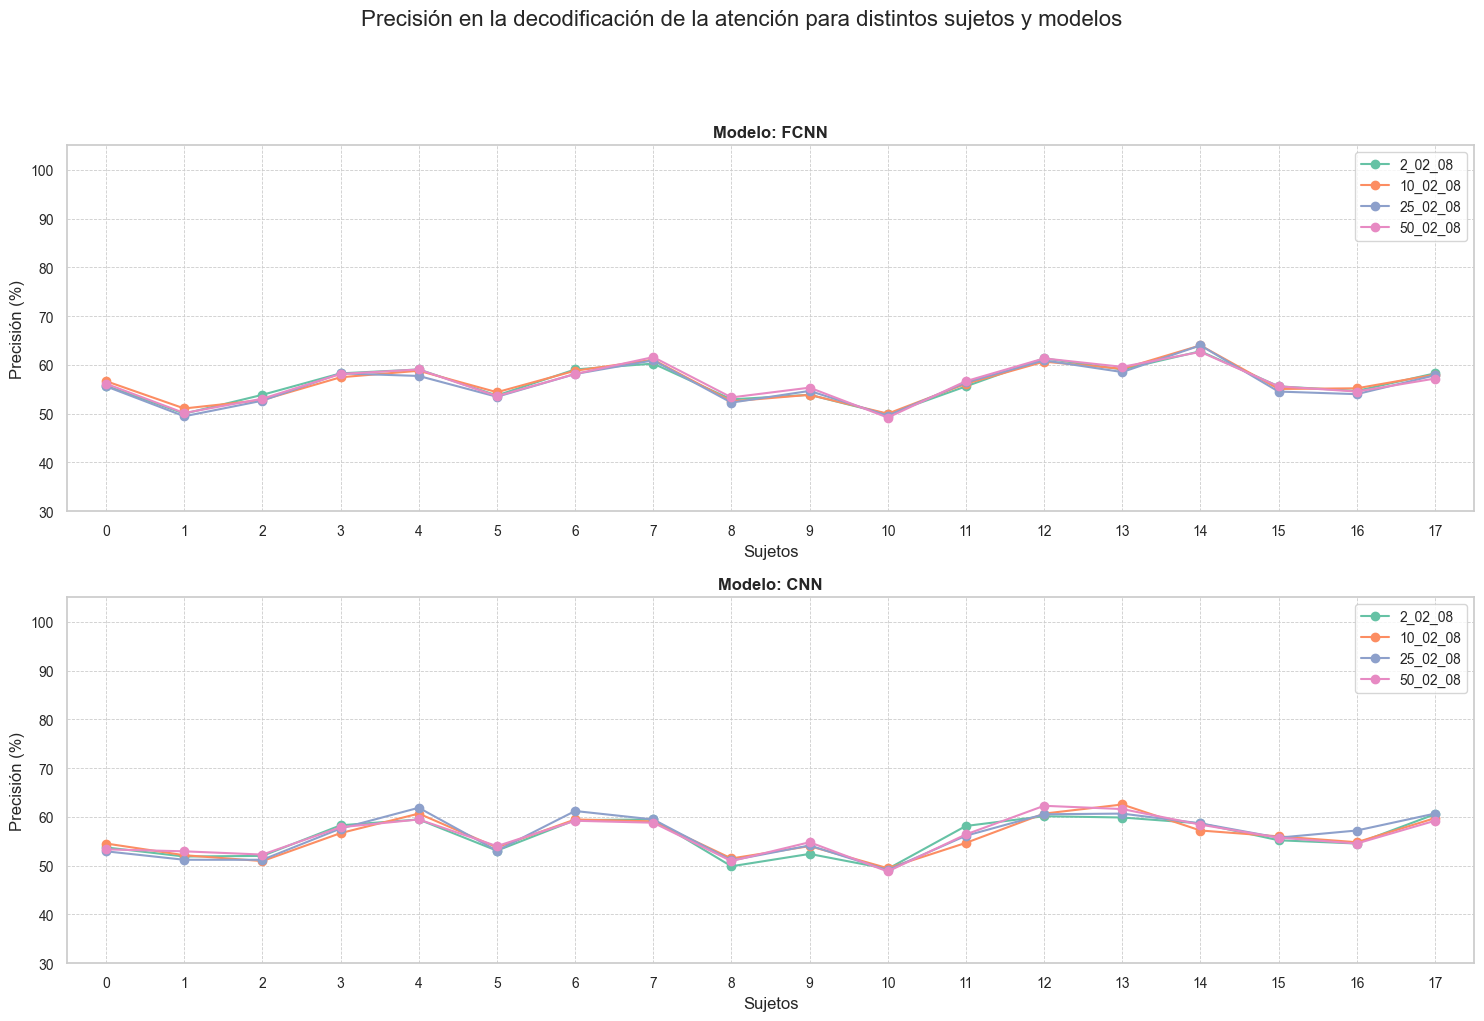

In [67]:
# Establecer estilo de seaborn
sns.set(style="whitegrid")

# Crear la figura y una matriz de subfiguras
fig, axs = plt.subplots(nrows=len(model_info), ncols=1, figsize=(15, 5 * len(model_info)))

# Aplanar la matriz de subfiguras para un acceso fácil
if len(model_info) == 1:
    axs = [axs]  # Convertir en lista si es un solo subplot
else:
    axs = axs.flatten()

# Paleta de colores de seaborn
colors = sns.color_palette("Set2", len(time_keys))  # Tres colores diferentes

# Crear las subfiguras
for n, (idx, tms_info) in enumerate(model_info.items()):
    
    x = range(len(tms_info[list(time_keys)[0]]))

    for i, time in enumerate(list(time_keys)):
        axs[n].plot(x, tms_info[time], linestyle='-', marker='o', color=colors[i], label=time)
    
    # Añadir título y etiquetas
    axs[n].set_title(f'Modelo: {idx}', fontweight='bold')
    axs[n].set_xlabel('Sujetos', fontsize=12)
    axs[n].set_ylabel('Precisión (%)', fontsize=12)
    axs[n].set_ylim([30, 105])
    axs[n].set_xlim([-0.5, 17.5])
    
    # Añadir rejilla para mayor legibilidad
    axs[n].grid(True, linestyle='--', linewidth=0.6)
    
    # Personalizar ejes
    axs[n].tick_params(axis='both', which='major', labelsize=10)
    
    # Configurar el eje x para mostrar números enteros
    axs[n].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

    # Configurar el eje x para mostrar números enteros y todos los índices
    axs[n].set_xticks(x)
    axs[n].set_xticklabels(x)
    
    # Añadir leyenda
    axs[n].legend(loc='best', fontsize=10)

# Eliminar subfiguras vacías si hay menos subfiguras que lugares en la cuadrícula
if len(model_info) < len(axs):
    for ax in axs[len(model_info):]:
        fig.delaxes(ax)

# Ajustar el layout
plt.tight_layout()
# Agregar un título general a la figura
fig.suptitle('Precisión en la decodificación de la atención para distintos sujetos y modelos', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajustar el layout para dejar espacio para el título

# Mostrar la gráfica
plt.show()